In [125]:
import matplotlib
import matplotlib.pyplot as plt
import time
import json
import pandas as pd
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from itertools import combinations

In [126]:
pre_preprocessed = pd.read_csv('intermediary_datasets/extracted_topics.csv')
# pre_preprocessed = pd.read_csv('intermediary_datasets/sales_analysis.csv')

In [127]:
pre_processed = pre_preprocessed.iloc[0:100000]
pre_preprocessed.head()

Unnamed: 0                          Description  Quantity  \
0           0   WHITE HANGING HEART T-LIGHT HOLDER         6   
1           1                  WHITE METAL LANTERN         6   
2           2       CREAM CUPID HEARTS COAT HANGER         8   
3           3  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4           4       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  Spending  \
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom     15.30   
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34   
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom     22.00   
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34   
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34   

   RFM_SCORE     segment category  
0         15  cant_loose   tlight  
1         15  cant_loose  lantern  
2         15  cant_loose    cupid  
3         15  cant_loose  knitted  
4         15  cant_loose   woolly

In [128]:
pre_preprocessed.drop(['Description', 'Unnamed: 0', 'CustomerID', 'Country'], inplace=True, axis=1)

In [129]:
pre_preprocessed['InvoiceDate'] = pd.to_datetime(pre_preprocessed['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')

In [130]:
pre_preprocessed['year'] = pre_preprocessed['InvoiceDate'].dt.year
pre_preprocessed['month'] = pre_preprocessed['InvoiceDate'].dt.month
pre_preprocessed['day_of_week'] = pre_preprocessed['InvoiceDate'].dt.dayofweek

In [131]:
pre_preprocessed.drop(['InvoiceDate'], inplace=True, axis=1)

In [132]:
# List all categorical columns
categorical = pre_preprocessed.select_dtypes(include=['object'])
categorical

segment category
0           cant_loose   tlight
1           cant_loose  lantern
2           cant_loose    cupid
3           cant_loose  knitted
4           cant_loose   woolly
...                ...      ...
99995  loyal_customers    budah
99996  loyal_customers   puppet
99997  loyal_customers  bedroom
99998  loyal_customers  growing
99999  loyal_customers   warmer

[100000 rows x 2 columns]

In [133]:
# One_hot_encode categorical variables
transformer = make_column_transformer((OneHotEncoder(), list(categorical.columns)))
transformed = transformer.fit_transform(pre_preprocessed)

In [134]:
categorical_columns = list(categorical.columns)
cleaned_categorical_features = []
for features in transformer.get_feature_names():
    feature_no = features.split('_')[2][1:]
    cleaned_categorical_features.append(categorical_columns[int(feature_no)] + '_' + re.sub(r'\w*__', '', features))

C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [135]:
transformed_df = pd.DataFrame.sparse.from_spmatrix(transformed, columns = cleaned_categorical_features)
transformed_df.head()

segment_x0_about_to_sleep  segment_x0_at_Risk  segment_x0_cant_loose  \
0                        0.0                 0.0                    1.0   
1                        0.0                 0.0                    1.0   
2                        0.0                 0.0                    1.0   
3                        0.0                 0.0                    1.0   
4                        0.0                 0.0                    1.0   

   segment_x0_champions  segment_x0_hibernating  segment_x0_loyal_customers  \
0                   0.0                     0.0                         0.0   
1                   0.0                     0.0                         0.0   
2                   0.0                     0.0                         0.0   
3                   0.0                     0.0                         0.0   
4                   0.0                     0.0                         0.0   

   segment_x0_need_attention  segment_x0_potential_loyalists  \
0                        0.0                             0.0   
1                        0.0                             0.0   
2                        0.0                             0.0   
3                        0.0                             0.0   
4                        0.0                             0.0   

   category_x1_120cm  category_x1_125g  ...  category_x1_woolly  \
0                0.0               0.0  ...                 0.0   
1                0.0               0.0  ...                 0.0   
2                0.0               0.0  ...                 0.0   
3                0.0               0.0  ...                 0.0   
4                0.0               0.0  ...                 1.0   

   category_x1_word  category_x1_wrap  category_x1_wrapping  \
0               0.0               0.0                   0.0   
1               0.0               0.0                   0.0   
2               0.0               0.0                   0.0   
3               0.0               0.0                   0.0   
4               0.0               0.0                   0.0   

   category_x1_wreath  category_x1_writing  category_x1_yellow  \
0                 0.0                  0.0                 0.0   
1                 0.0                  0.0                 0.0   
2                 0.0                  0.0                 0.0   
3                 0.0                  0.0                 0.0   
4                 0.0                  0.0                 0.0   

   category_x1_youre  category_x1_yuletide  category_x1_zinc  
0                0.0                   0.0               0.0  
1                0.0                   0.0               0.0  
2                0.0                   0.0               0.0  
3                0.0                   0.0               0.0  
4                0.0                   0.0               0.0  

[5 rows x 1187 columns]

In [137]:
# Assume X is your feature matrix with the numeric columns you want to scale
scaler = StandardScaler()
pre_processed_scaled = scaler.fit_transform(pre_preprocessed.select_dtypes(exclude=['object']))
pre_processed_scaled = pd.DataFrame(pre_processed_scaled, columns = pre_preprocessed.select_dtypes(exclude=['object']).columns)

In [140]:
# Join back with numerical cols
pre_processed_scaled
ohe_pre_preprocessed = pre_processed_scaled.join(transformed_df)
ohe_pre_preprocessed

Quantity  UnitPrice  Spending  RFM_SCORE      year     month  \
0     -0.132567  -0.020187 -0.084005  -3.266237 -2.380383  1.185742   
1     -0.132567  -0.002431 -0.034905  -3.266237 -2.380383  1.185742   
2     -0.097043  -0.015959 -0.018733  -3.266237 -2.380383  1.185742   
3     -0.132567  -0.002431 -0.034905  -3.266237 -2.380383  1.185742   
4     -0.132567  -0.002431 -0.034905  -3.266237 -2.380383  1.185742   
...         ...        ...       ...        ...       ...       ...   
99995 -0.221376  -0.071976 -0.232084  -0.506431  0.420100  0.908211   
99996 -0.221376  -0.011732 -0.204319  -0.506431  0.420100  0.908211   
99997 -0.221376  -0.029699 -0.212600  -0.506431  0.420100  0.908211   
99998 -0.203614  -0.056123 -0.216497  -0.506431  0.420100  0.908211   
99999 -0.203614  -0.029699 -0.192142  -0.506431  0.420100  0.908211   

       day_of_week  segment_x0_about_to_sleep  segment_x0_at_Risk  \
0        -0.308208                        0.0                 0.0   
1        -0.308208                        0.0                 0.0   
2        -0.308208                        0.0                 0.0   
3        -0.308208                        0.0                 0.0   
4        -0.308208                        0.0                 0.0   
...            ...                        ...                 ...   
99995     0.221778                        0.0                 0.0   
99996     0.221778                        0.0                 0.0   
99997     0.221778                        0.0                 0.0   
99998     0.221778                        0.0                 0.0   
99999     0.221778                        0.0                 0.0   

       segment_x0_cant_loose  ...  category_x1_woolly  category_x1_word  \
0                        1.0  ...                 0.0               0.0   
1                        1.0  ...                 0.0               0.0   
2                        1.0  ...                 0.0               0.0   
3                        1.0  ...                 0.0               0.0   
4                        1.0  ...                 1.0               0.0   
...                      ...  ...                 ...               ...   
99995                    0.0  ...                 0.0               0.0   
99996                    0.0  ...                 0.0               0.0   
99997                    0.0  ...                 0.0               0.0   
99998                    0.0  ...                 0.0               0.0   
99999                    0.0  ...                 0.0               0.0   

       category_x1_wrap  category_x1_wrapping  category_x1_wreath  \
0                   0.0                   0.0                 0.0   
1                   0.0                   0.0                 0.0   
2                   0.0                   0.0                 0.0   
3                   0.0                   0.0                 0.0   
4                   0.0                   0.0                 0.0   
...                 ...                   ...                 ...   
99995               0.0                   0.0                 0.0   
99996               0.0                   0.0                 0.0   
99997               0.0                   0.0                 0.0   
99998               0.0                   0.0                 0.0   
99999               0.0                   0.0                 0.0   

       category_x1_writing  category_x1_yellow  category_x1_youre  \
0                      0.0                 0.0                0.0   
1                      0.0                 0.0                0.0   
2                      0.0                 0.0                0.0   
3                      0.0                 0.0                0.0   
4                      0.0                 0.0                0.0   
...                    ...                 ...                ...   
99995                  0.0                 0.0                0.0   
99996                  0.0                 

In [150]:
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(ohe_pre_preprocessed)
    clusters = kmeans.predict(ohe_pre_preprocessed)
    silhouette_avg = silhouette_score(ohe_pre_preprocessed, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.34532540196244205


C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.2345231539649012


C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.17988874741919997


C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.17866812101201576


C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.17517574774912772


C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.19087211228091763


C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


KeyboardInterrupt: 

In [164]:
kmeans = KMeans(init='k-means++', n_clusters = 3, n_init=30)
km_fit = kmeans.fit(ohe_pre_preprocessed)

C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [165]:
clusters = kmeans.predict(ohe_pre_preprocessed)

C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [166]:
pd.Series(clusters).value_counts()

1    62170
0    22829
2    15001
dtype: int64

C:\Users\peh_s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


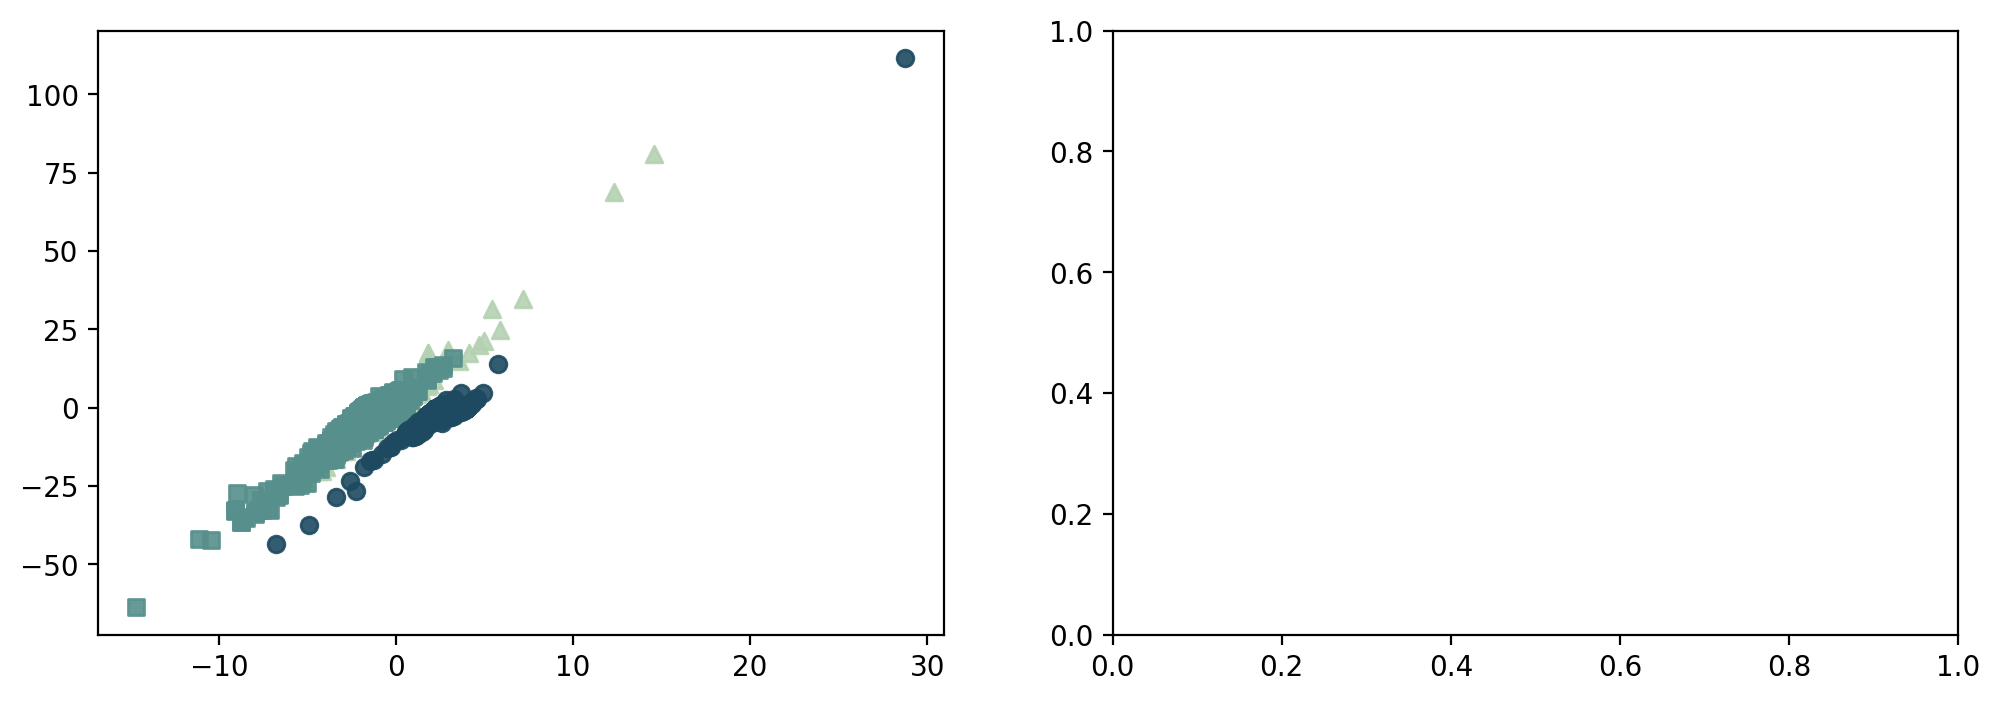

In [167]:
# Visualizing pca and pacmap
from sklearn.decomposition import PCA

cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), dpi=200)

# PCA
pca_scaled_std = PCA(n_components=2,random_state=42)
X_std_pca = pca_scaled_std.fit_transform(ohe_pre_preprocessed)

for l, c, m in zip(range(0, 3), cluster_colors[0:km_fit.n_clusters], ('^', 's', 'o')):
    ax1.scatter(X_std_pca[clusters == l, 0],
                X_std_pca[clusters == l, 1],
                color=c,
                label='cluster %s' % l,
                alpha=0.9,
                marker=m
                )

In [171]:
X = ohe_pre_preprocessed
y = clusters

In [172]:
X_mean = pd.concat([pd.DataFrame(X.mean().drop('cluster'), columns=['mean']), 
                   X.groupby('cluster').mean().T], axis=1)

X_dev_rel = X_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
X_dev_rel.drop(columns=['mean'], inplace=True)
X_mean.drop(columns=['mean'], inplace=True)

C:\Users\peh_s\AppData\Local\Temp\ipykernel_1852\4255653221.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


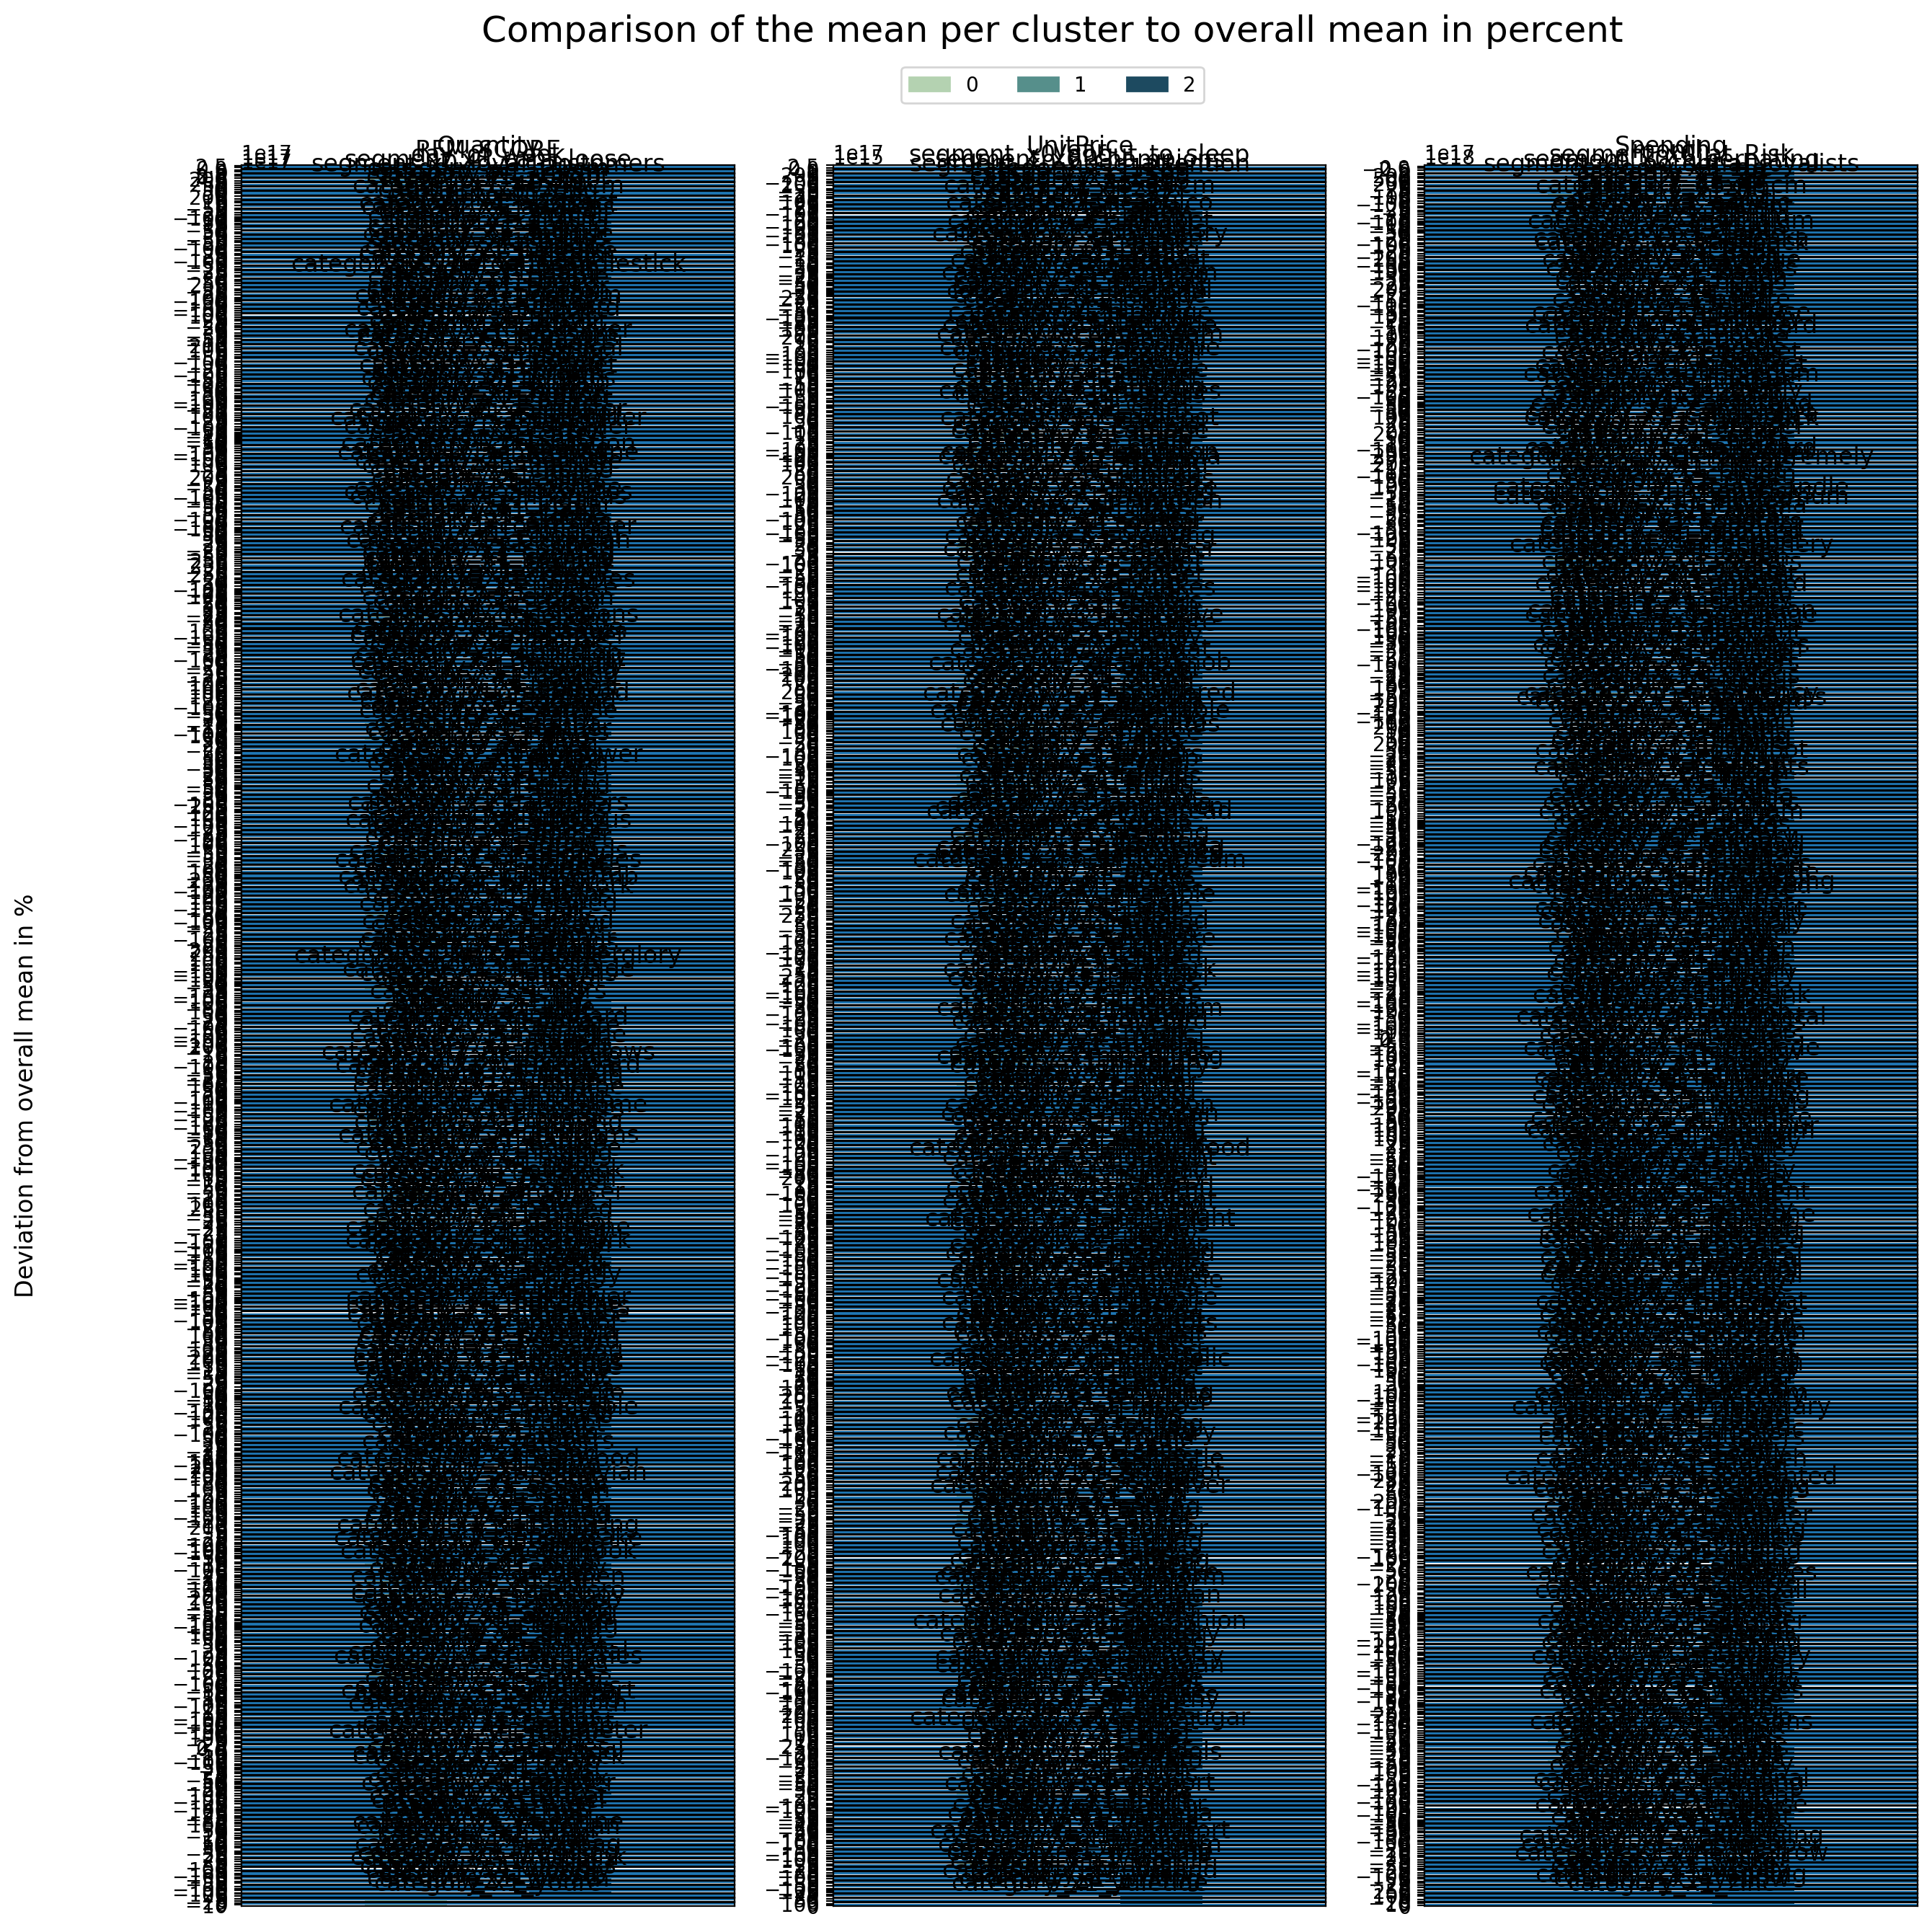

In [173]:
import matplotlib.patches as mpatches
def cluster_comparison_bar(X_comparison, colors, deviation=True ,title="Cluster results"):
    
    features = X_comparison.index
    ncols = 3
    # calculate number of rows
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    # set figure size
    fig = plt.figure(figsize=(15,15), dpi=200)
    #interate through every feature
    for n, feature in enumerate(features):
        # create chart
        ax = plt.subplot(nrows, ncols, n + 1)
        X_comparison[X_comparison.index==feature].plot(kind='bar', ax=ax, title=feature, 
                                                             color=colors[0:X.cluster.nunique()],
                                                             legend=False
                                                            )
        plt.axhline(y=0)
        x_axis = ax.axes.get_xaxis()
        x_axis.set_visible(False)

    c_labels = X_comparison.columns.to_list()
    c_colors = colors[0:3]
    mpats = [mpatches.Patch(color=c, label=l) for c,l in list(zip(colors[0:X.cluster.nunique()],
                                                                  X_comparison.columns.to_list()))]

    fig.legend(handles=mpats,
               ncol=ncols,
               loc="upper center",
               fancybox=True,
               bbox_to_anchor=(0.5, 0.98)
              )
    axes = fig.get_axes()
    
    fig.suptitle(title, fontsize=18, y=1)
    fig.supylabel('Deviation from overall mean in %')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
cluster_comparison_bar(X_dev_rel, cluster_colors, title="Comparison of the mean per cluster to overall mean in percent")


In [ ]:
colors = ['#9EBD6E','#81a094','#775b59','#32161f', '#946846', '#E3C16F', '#fe938c', '#E6B89C','#EAD2AC',
          '#DE9E36', '#4281A4','#37323E','#95818D'
         ]

fig = plt.figure(figsize=(10,5), dpi=200)
X_dev_rel.T.plot(kind='bar', 
                       ax=fig.add_subplot(), 
                       title="Cluster characteristics", 
                       color=colors,
                       xlabel="Cluster",
                       ylabel="Deviation from overall mean in %"
                      )
plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(bbox_to_anchor=(1.04,1))
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [161]:
# ohe_pre_preprocessed_and_clusters = X.join(pd.DataFrame(y))

In [169]:
X['cluster'] = kmeans.labels_

ValueError: Grouper for 'cluster' not 1-dimensional

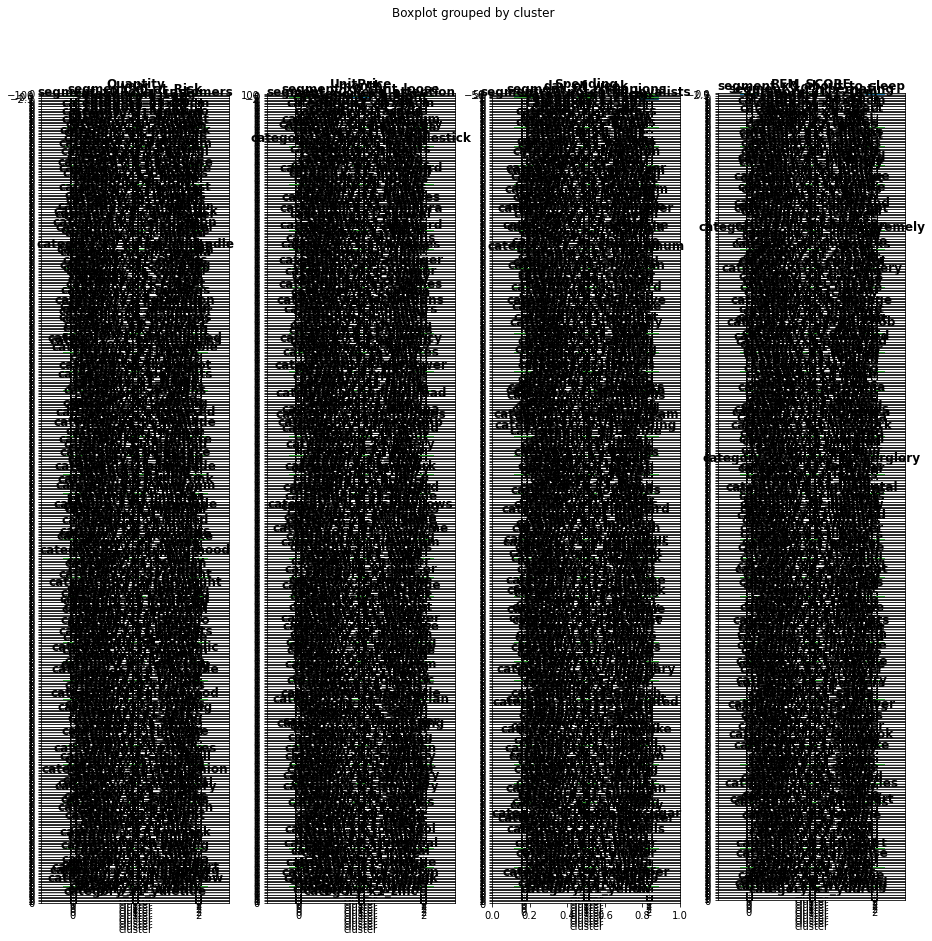

In [170]:
features = kmeans.feature_names_in_
ncols = 4
nrows = len(features) // ncols + (len(features) % ncols > 0)
fig = plt.figure(figsize=(15,15))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n + 1)
    box = X[[feature, 'cluster']].boxplot(by='cluster',ax=ax,return_type='both',patch_artist = True)

    for row_key, (ax,row) in box.iteritems():
        ax.set_xlabel('cluster')
        ax.set_title(feature,fontweight="bold")
        for i,box in enumerate(row['boxes']):
            box.set_facecolor(cluster_colors[i])

fig.suptitle('Feature distributions per cluster', fontsize=18, y=1)   
plt.tight_layout()
plt.show()

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [158]:
%store X_train X_test y_train y_test kmeans

Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'kmeans' (KMeans)


----------

In [148]:
X_test.drop(columns = X_test.columns[X_test.columns.str.contains('_')]).drop(['segment', 'category'], axis= 1)

KeyError: "['segment' 'category'] not found in axis"

In [58]:
# Scale X_train and X_test
train_numerical_columns = X_train.drop(columns = X_train.columns[X_test.columns.str.contains('_')]).drop(['segment', 'category'], axis= 1)
test_numerical_columns = X_test.drop(columns = X_test.columns[X_test.columns.str.contains('_')]).drop(['segment', 'category'], axis= 1)
ss = StandardScaler()

train_numerical_columns_scaled = ss.fit_transform(train_numerical_columns)
test_numerical_columns_scaled  = ss.transform(test_numerical_columns)
train_numerical_columns = pd.DataFrame(train_numerical_columns_scaled, columns = train_numerical_columns.columns)
test_numerical_columns = pd.DataFrame(test_numerical_columns_scaled, columns = test_numerical_columns.columns)

In [59]:
# Reset indexes of categorical columns
train_cat_columns = X_train[X_train.columns[X_train.columns.str.contains('_')]].reset_index(drop=True)
test_cat_columns = X_test[X_test.columns[X_test.columns.str.contains('_')]].reset_index(drop=True)

In [60]:
# Join numerical cols back with categorical cols
X_train = train_numerical_columns.join(train_cat_columns)
X_test = test_numerical_columns.join(test_cat_columns)

In [61]:
X_train

Quantity  UnitPrice  Spending      year     month  RFM_SCORE  \
0     -0.093057  -0.050829 -0.140258  0.419116 -0.479840         55   
1     -0.213485  -0.041669 -0.224099  0.419116 -0.479840         55   
2     -0.161873  -0.011900 -0.122184 -2.385976  1.185500         55   
3     -0.213485  -0.061362 -0.232734  0.419116  0.907944         55   
4     -0.058649  -0.070522 -0.201507  0.419116  0.907944         55   
...         ...        ...       ...       ...       ...        ...   
79995 -0.213485   0.148396 -0.140760  0.419116 -0.479840         25   
79996 -0.213485  -0.031364 -0.219581 -2.385976  1.185500         55   
79997 -0.213485  -0.041669 -0.224099  0.419116  0.352830         55   
79998 -0.024240  -0.041669 -0.041858  0.419116 -1.590067         25   
79999 -0.179077  -0.069835 -0.228015  0.419116 -1.034954         34   

       day_of_week  
0                6  
1                6  
2                1  
3                0  
4                6  
...            ...  
79995            3  
79996            2  
79997            3  
79998            2  
79999            6  

[80000 rows x 7 columns]

In [62]:
X_test

Quantity  UnitPrice  Spending      year     month  RFM_SCORE  \
0     -0.213485  -0.062278 -0.233136  0.419116  0.630387         55   
1     -0.093057  -0.060446 -0.173995  0.419116  0.630387         43   
2      0.199412  -0.069835 -0.135238  0.419116 -1.867624         55   
3     -0.213485  -0.031364 -0.219581  0.419116 -1.867624         55   
4      0.199412  -0.069835 -0.135238  0.419116 -0.757397         55   
...         ...        ...       ...       ...       ...        ...   
19995 -0.196281  -0.046249 -0.211548  0.419116  0.907944         55   
19996 -0.213485  -0.066858 -0.235144  0.419116 -0.757397         55   
19997 -0.196281   0.109467 -0.074993  0.419116  0.907944         55   
19998 -0.179077  -0.059988 -0.215062  0.419116  0.630387         55   
19999 -0.127465  -0.011900 -0.062944  0.419116 -1.867624         45   

       day_of_week  
0                6  
1                1  
2                0  
3                2  
4                2  
...            ...  
19995            2  
19996            1  
19997            2  
19998            2  
19999            0  

[20000 rows x 7 columns]